In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from hyperopt import hp, STATUS_OK, fmin, tpe, Trials
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier

# 당요병 예측

In [2]:
df = pd.read_csv('./diabetes_datasets/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#결측치 없음
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
X = df.iloc[:,:8]
y = df.iloc[:, 8]

## 원본 데이터 모델 성능

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

In [6]:
def apply_models(model=None, X_train=None, y_train=None, X_validation=None, y_validation=None):
    if model == 'logistic':
        logistic = LogisticRegression(random_state=123, n_jobs=-1).fit(X_train, y_train)
        logistic_yhat = logistic.predict(X_validation)
        print('logistic accuracy score: ', accuracy_score(y_validation, logistic_yhat))
        print('logistic precision score: ', precision_score(y_validation, logistic_yhat))
        print('logistic recall score: ', recall_score(y_validation, logistic_yhat))
        print('logistic f1 score: ', f1_score(y_validation, logistic_yhat))
        print('logistic roc_auc score: ', roc_auc_score(y_validation, logistic_yhat))
        print()
    elif model == 'rf':
        rf = RandomForestClassifier(random_state=123, n_jobs=-1).fit(X_train, y_train)
        rf_yhat = rf.predict(X_validation)
        print('RF accuracy score: ', accuracy_score(y_validation, rf_yhat))
        print('RF precision score: ', precision_score(y_validation, rf_yhat))
        print('RF recall score: ', recall_score(y_validation, rf_yhat))
        print('RF f1 score: ', f1_score(y_validation, rf_yhat))
        print('RF roc_auc score: ', roc_auc_score(y_validation, rf_yhat))
        print()
    elif model == 'xgb':
        xgb = XGBClassifier(objective='binary:logistic', random_state=123, n_jobs=-1).fit(X_train, y_train)
        xgb_yhat = xgb.predict(X_validation)
        print('xgb accuracy score: ', accuracy_score(y_validation, xgb_yhat))
        print('xgb precision score: ', precision_score(y_validation, xgb_yhat))
        print('xgb recall score: ', recall_score(y_validation, xgb_yhat))
        print('xgb f1 score: ', f1_score(y_validation, xgb_yhat))
        print('xgb roc_auc score: ', roc_auc_score(y_validation, xgb_yhat))
        print()
    elif model == 'lgbm':
        lgbm = LGBMClassifier(random_state=123, n_jobs=-1).fit(X_train, y_train)
        lgbm_yhat = lgbm.predict(X_validation)
        print('lgbm accuracy score: ', accuracy_score(y_validation, lgbm_yhat))
        print('lgbm precision score: ', precision_score(y_validation, lgbm_yhat))
        print('lgbm recall score: ', recall_score(y_validation, lgbm_yhat))
        print('lgbm f1 score: ', f1_score(y_validation, lgbm_yhat))
        print('lgbm roc_auc score: ', roc_auc_score(y_validation, lgbm_yhat))
        print()
    else:
        print('The specified model is not supported. Please choose from "logistic", "rf", "xgb", or "lgbm".')
        

In [7]:
#원본데이터 모델 성능
models = ['logistic', 'rf', 'xgb', 'lgbm']

for model in models:
    apply_models(model=model, X_train=X_train, y_train=y_train, X_validation=X_val, y_validation=y_val)

logistic accuracy score:  0.7723577235772358
logistic precision score:  0.7419354838709677
logistic recall score:  0.5348837209302325
logistic f1 score:  0.6216216216216216
logistic roc_auc score:  0.7174418604651164

RF accuracy score:  0.7479674796747967
RF precision score:  0.75
RF recall score:  0.4186046511627907
RF f1 score:  0.5373134328358209
RF roc_auc score:  0.6718023255813955

xgb accuracy score:  0.7154471544715447
xgb precision score:  0.625
xgb recall score:  0.46511627906976744
xgb f1 score:  0.5333333333333333
xgb roc_auc score:  0.6575581395348836

lgbm accuracy score:  0.7560975609756098
lgbm precision score:  0.7096774193548387
lgbm recall score:  0.5116279069767442
lgbm f1 score:  0.5945945945945946
lgbm roc_auc score:  0.6995639534883721



## Over Sampling SMOTE 적용

In [8]:
#종속변수 분포확인
print('원본:',df['Outcome'].value_counts()/len(df['Outcome'])*100)
print()
print('학습:',y_train.value_counts()/y_train.shape[0]*100)
print()
print('검증:',y_val.value_counts()/y_val.shape[0]*100)
print()
print('테스트:',y_test.value_counts()/y_test.shape[0]*100)

원본: Outcome
0    65.104167
1    34.895833
Name: count, dtype: float64

학습: Outcome
0    65.173116
1    34.826884
Name: count, dtype: float64

검증: Outcome
0    65.04065
1    34.95935
Name: count, dtype: float64

테스트: Outcome
0    64.935065
1    35.064935
Name: count, dtype: float64


In [9]:
#OverSampling use SMOTE
smote = SMOTE(n_jobs=-1, random_state=123)
X_over_tr, y_over_tr = smote.fit_resample(X_train, y_train)
print('smote 전 X,y: ', X_train.shape, y_train.shape)
print('smote 후 X,y: ', X_over_tr.shape, y_over_tr.shape)

smote 전 X,y:  (491, 8) (491,)
smote 후 X,y:  (640, 8) (640,)


C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [10]:
print('학습 SMOTE 적용 전: ',y_train.value_counts()/y_train.shape[0]*100)
print()
print('SMOTE: ',y_over_tr.value_counts()/y_over_tr.shape[0]*100)

학습 SMOTE 적용 전:  Outcome
0    65.173116
1    34.826884
Name: count, dtype: float64

SMOTE:  Outcome
1    50.0
0    50.0
Name: count, dtype: float64


In [11]:
X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_tr, y_over_tr, test_size=0.2, stratify=y_over_tr, random_state=123)

In [12]:
print('학습 SMOTE 적용 전: ',y_train.value_counts()/y_train.shape[0]*100)
print()
print('SMOTE val: ',y_over_val.value_counts()/y_over_val.shape[0]*100)

학습 SMOTE 적용 전:  Outcome
0    65.173116
1    34.826884
Name: count, dtype: float64

SMOTE val:  Outcome
1    50.0
0    50.0
Name: count, dtype: float64


In [13]:
#Over Sampling SMOTE 적용 후 모델 성능 체크
models = ['logistic', 'rf', 'xgb', 'lgbm']

for model in models:
    apply_models(model=model, X_train=X_over_tr, y_train=y_over_tr, X_validation=X_over_val, y_validation=y_over_val)

logistic accuracy score:  0.7109375
logistic precision score:  0.7076923076923077
logistic recall score:  0.71875
logistic f1 score:  0.7131782945736435
logistic roc_auc score:  0.7109375

RF accuracy score:  0.8125
RF precision score:  0.7777777777777778
RF recall score:  0.875
RF f1 score:  0.8235294117647058
RF roc_auc score:  0.8125

xgb accuracy score:  0.796875
xgb precision score:  0.7714285714285715
xgb recall score:  0.84375
xgb f1 score:  0.8059701492537313
xgb roc_auc score:  0.796875

lgbm accuracy score:  0.7578125
lgbm precision score:  0.7391304347826086
lgbm recall score:  0.796875
lgbm f1 score:  0.7669172932330827
lgbm roc_auc score:  0.7578125



## 피쳐 스케일링 정규화 

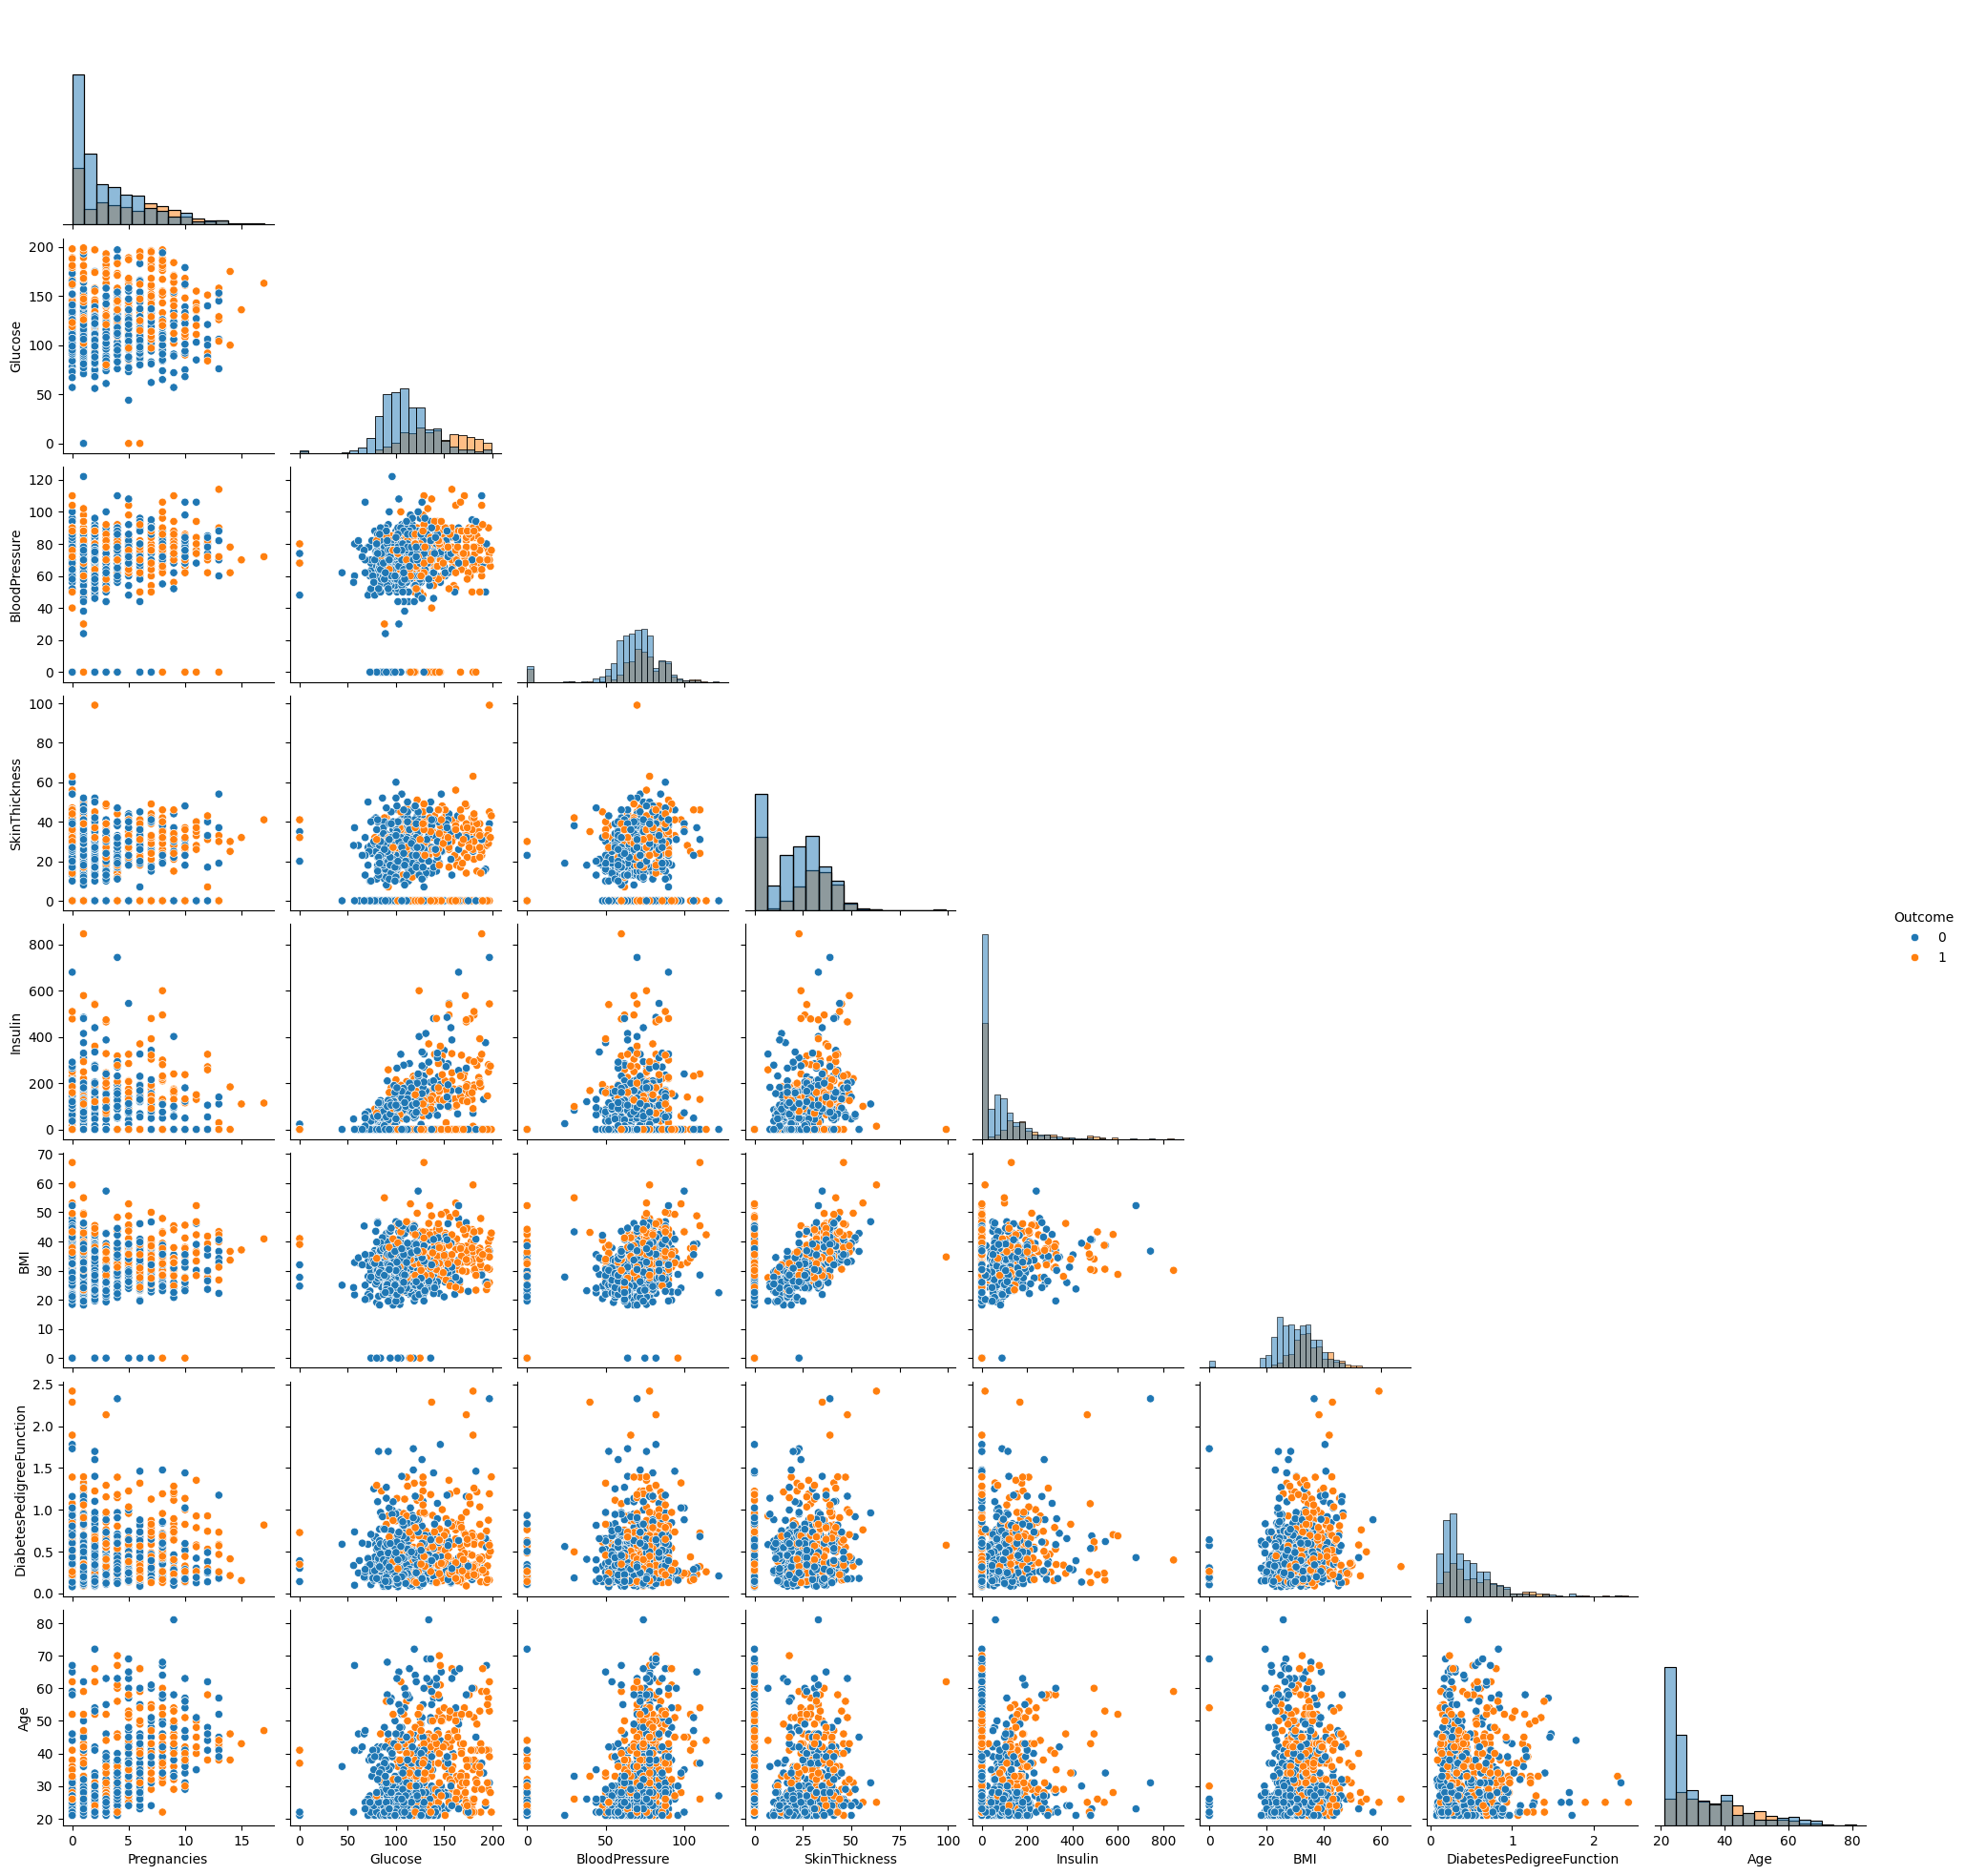

In [14]:
#독립변수들간의 분포도 확인
# pregnacies, skinThickness, insulin, DiabetesPedigreeFunction, Age 독립변수들이 오른쪽으로 분포되어있음.
sns.pairplot(df, diag_kind="hist", hue='Outcome',  corner=True)

In [15]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [16]:
def apply_scale(method='None', data=None):
    if method == 'standard':
        scaled_data = StandardScaler().fit_transform(data)
    elif method == 'minmax':
        scaled_data = MinMaxScaler().fit_transform(data)
    elif method == 'log':
        scaled_data = np.log1p(data)
    else:
        print(f"Unrecognized scaling method '{method}'. No scaling applied.")
        scaled_data = data
    return scaled_data

In [17]:
methods = ['standard', 'minmax', 'log']
scaled_df = []
for method in methods:
    transform_df = apply_scale(method=method, data=X)
    scaled_df.append(transform_df)

In [18]:
X_standard = scaled_df[0]
X_standard

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [19]:
X_minmax = scaled_df[1]
X_minmax 

array([[0.35294118, 0.74371859, 0.59016393, ..., 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, ..., 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, ..., 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, ..., 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, ..., 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, ..., 0.45305514, 0.10119556,
        0.03333333]])

In [20]:
X_log = scaled_df[2]
X_log

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.945910,5.003946,4.290459,3.583519,0.000000,3.543854,0.486738,3.931826
1,0.693147,4.454347,4.204693,3.401197,0.000000,3.317816,0.300845,3.465736
2,2.197225,5.214936,4.174387,0.000000,0.000000,3.190476,0.514021,3.496508
3,0.693147,4.499810,4.204693,3.178054,4.553877,3.370738,0.154436,3.091042
4,0.000000,4.927254,3.713572,3.583519,5.129899,3.786460,1.190279,3.526361
...,...,...,...,...,...,...,...,...
763,2.397895,4.624973,4.343805,3.891820,5.198497,3.523415,0.157858,4.158883
764,1.098612,4.812184,4.262680,3.332205,0.000000,3.632309,0.292670,3.332205
765,1.791759,4.804021,4.290459,3.178054,4.727388,3.303217,0.219136,3.433987
766,0.693147,4.844187,4.110874,0.000000,0.000000,3.437208,0.299364,3.871201


### Standard_scaler 변환 모델 성능 체크

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(n_jobs=-1, random_state=123)
X_over_tr, y_over_tr = smote.fit_resample(X_train, y_train)

X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_tr, y_over_tr, test_size=0.2, stratify=y_over_tr, random_state=123)

models = ['logistic', 'rf', 'xgb', 'lgbm']

for model in models:
    apply_models(model=model, X_train=X_over_tr, y_train=y_over_tr, X_validation=X_over_val, y_validation=y_over_val)

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


logistic accuracy score:  0.75
logistic precision score:  0.7941176470588235
logistic recall score:  0.675
logistic f1 score:  0.7297297297297297
logistic roc_auc score:  0.75

RF accuracy score:  0.7875
RF precision score:  0.8026315789473685
RF recall score:  0.7625
RF f1 score:  0.782051282051282
RF roc_auc score:  0.7874999999999999

xgb accuracy score:  0.8
xgb precision score:  0.8243243243243243
xgb recall score:  0.7625
xgb f1 score:  0.7922077922077922
xgb roc_auc score:  0.8

lgbm accuracy score:  0.8
lgbm precision score:  0.8
lgbm recall score:  0.8
lgbm f1 score:  0.8
lgbm roc_auc score:  0.8



### MinMax_scaler 변환 모델 성능 체크

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(n_jobs=-1, random_state=123)
X_over_tr, y_over_tr = smote.fit_resample(X_train, y_train)

X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_tr, y_over_tr, test_size=0.2, stratify=y_over_tr, random_state=123)

models = ['logistic', 'rf', 'xgb', 'lgbm']

for model in models:
    apply_models(model=model, X_train=X_over_tr, y_train=y_over_tr, X_validation=X_over_val, y_validation=y_over_val)

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


logistic accuracy score:  0.75
logistic precision score:  0.7941176470588235
logistic recall score:  0.675
logistic f1 score:  0.7297297297297297
logistic roc_auc score:  0.75

RF accuracy score:  0.80625
RF precision score:  0.810126582278481
RF recall score:  0.8
RF f1 score:  0.8050314465408805
RF roc_auc score:  0.8062500000000001

xgb accuracy score:  0.78125
xgb precision score:  0.7710843373493976
xgb recall score:  0.8
xgb f1 score:  0.7852760736196319
xgb roc_auc score:  0.78125

lgbm accuracy score:  0.7875
lgbm precision score:  0.7804878048780488
lgbm recall score:  0.8
lgbm f1 score:  0.7901234567901234
lgbm roc_auc score:  0.7875



### Log_scaler 변환 모델 성능 체크

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(n_jobs=-1, random_state=123)
X_over_tr, y_over_tr = smote.fit_resample(X_train, y_train)

X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_tr, y_over_tr, test_size=0.2, stratify=y_over_tr, random_state=123)

models = ['logistic', 'rf', 'xgb', 'lgbm']

for model in models:
    apply_models(model=model, X_train=X_over_tr, y_train=y_over_tr, X_validation=X_over_val, y_validation=y_over_val)

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


logistic accuracy score:  0.7625
logistic precision score:  0.7837837837837838
logistic recall score:  0.725
logistic f1 score:  0.7532467532467533
logistic roc_auc score:  0.7625000000000001

RF accuracy score:  0.78125
RF precision score:  0.7922077922077922
RF recall score:  0.7625
RF f1 score:  0.7770700636942676
RF roc_auc score:  0.7812500000000001

xgb accuracy score:  0.7875
xgb precision score:  0.7948717948717948
xgb recall score:  0.775
xgb f1 score:  0.7848101265822784
xgb roc_auc score:  0.7875

lgbm accuracy score:  0.80625
lgbm precision score:  0.8181818181818182
lgbm recall score:  0.7875
lgbm f1 score:  0.802547770700637
lgbm roc_auc score:  0.8062499999999999



SMOTE 적용 후 Standard Scaler 적용.
Standard Scaler를 적용했을때 accuracy score가 가장 높았다.

## 이상치 제거 후 모델 적용

In [24]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Initialize an empty DataFrame to hold the filtered data
rm_outlier_df = df.copy()

for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    
    # Keep only the rows that do not qualify as outliers in the current column
    rm_outlier_df = rm_outlier_df[(rm_outlier_df[column] >= lower_boundary) & (rm_outlier_df[column] <= upper_boundary)]

print(rm_outlier_df.shape)
print(df.shape)

(639, 9)
(768, 9)


In [25]:
X = rm_outlier_df.iloc[:,:8]
y = rm_outlier_df.iloc[:,8]

In [26]:
X_standard = apply_scale(method='standard', data=X)
X_standard

array([[ 0.67382449,  0.99135111, -0.01062636, ...,  0.24797421,
         0.7888924 ,  1.56113222],
       [-0.86065109, -1.170674  , -0.53973612, ..., -0.84085334,
        -0.31175881, -0.15491181],
       [ 1.28761472,  2.19247617, -0.71610604, ..., -1.35415776,
         0.96834641, -0.0645937 ],
       ...,
       [ 0.36692937,  0.06476892, -0.01062636, ..., -0.90307206,
        -0.73447269, -0.24522991],
       [-0.86065109,  0.23635821, -1.06884588, ..., -0.29643957,
        -0.31973455,  1.2901779 ],
       [-0.86065109, -0.89613113, -0.18699628, ..., -0.24977553,
        -0.45532202, -0.87745666]])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(n_jobs=-1, random_state=123)
X_over_tr, y_over_tr = smote.fit_resample(X_train, y_train)

X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_tr, y_over_tr, test_size=0.2, stratify=y_over_tr, random_state=123)

models = ['logistic', 'rf', 'xgb', 'lgbm']

for model in models:
    apply_models(model=model, X_train=X_over_tr, y_train=y_over_tr, X_validation=X_over_val, y_validation=y_over_val)

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


logistic accuracy score:  0.7021276595744681
logistic precision score:  0.75
logistic recall score:  0.6
logistic f1 score:  0.6666666666666666
logistic roc_auc score:  0.7014084507042254

RF accuracy score:  0.7801418439716312
RF precision score:  0.7910447761194029
RF recall score:  0.7571428571428571
RF f1 score:  0.7737226277372263
RF roc_auc score:  0.7799798792756539

xgb accuracy score:  0.7943262411347518
xgb precision score:  0.8059701492537313
xgb recall score:  0.7714285714285715
xgb f1 score:  0.7883211678832117
xgb roc_auc score:  0.7941649899396378

lgbm accuracy score:  0.7943262411347518
lgbm precision score:  0.7887323943661971
lgbm recall score:  0.8
lgbm f1 score:  0.7943262411347518
lgbm roc_auc score:  0.7943661971830986



## Soft_Voting 적용 

In [28]:
logistic = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

vo_clf = VotingClassifier(estimators=[('logistic', logistic), ('rf', rf), ('xgb', xgb), ('lgbm',lgbm)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.2, stratify=y, random_state=123)

smote = SMOTE(n_jobs=-1, random_state=123)
X_over_tr, y_over_tr = smote.fit_resample(X_train, y_train)

X_over_tr, X_over_val, y_over_tr, y_over_val = train_test_split(X_over_tr, y_over_tr, test_size=0.2, stratify=y_over_tr, random_state=123)

vo_clf.fit(X_over_tr, y_over_tr)
pred = vo_clf.predict(X_over_val)
print(f'Voting 분류기 정확도: {accuracy_score(y_over_val, pred)}, Precidion: {precision_score(y_over_val, pred)}, Recall: {recall_score(y_over_val, pred)}, f1: {f1_score(y_over_val, pred)}')

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Voting 분류기 정확도: 0.8156028368794326, Precidion: 0.8142857142857143, Recall: 0.8142857142857143, f1: 0.8142857142857143


Standard Scaler + SMOTE + Soft_Voting 적용했을때 81.5%의 가장 높은 정확도가 나왔다